# Lab Deep Learning / Multi-Layer Perceptron for regression / in pytorch

**Author: geoffroy.peeters@telecom-paris.fr**

For any remark or suggestion, please feel free to contact me.

Last edits:
- 2020/03/24 peeters (change dimensions order)
- 2020/04/27 peeters (added comments on W1, W2 initialization, added comments on A and B)
- 2021/05/05 peeters (add some documentation related to ```W1 -= ...```)
- 2023/05/10 peeters (typos corrections)
- 2024/05/02 peeters (link to do nn.Linear)

Read the "introduction to pytorch"
- slides: https://perso.telecom-paristech.fr/gpeeters/doc/pytorch/
- video: https://perso.telecom-paristech.fr/gpeeters/video/pytorch.mp4


## Objective:

The objective of this lab is to demonstrate the use of Neural Networks to perform non-linear regression.
We will use a simple NN with 1 hidden layer. The hidden layer has $n_h$ (you will test various values of $n_h$) hidden units and either a ```sigmoid```, ```relu``` or ```tanh``` activation.
Since we perform a regression task the output $\hat{y} \in \mathbb{R}$ and  there is no output activation (linear).

You will perform 1000 iterations (epochs) of SGD to find the parameters.

You will then apply the network to the two datasets A and B.

Note: for this lab, we do not separate the dataset into a train, validation and test part. We simply check the ```capacity``` of the network to model the training data.

**Question**: according to the obtained loss, discuss the choice of ```sigmoid```, ```relu``` or ```tanh```.



### Data normalization

You should normalize the data to zero mean and unit standard deviation

### Model

There are various ways to write a NN model in pytorch.

In this lab, you will write three different implementations:
- **Model A**: manually defining the parameters (W1,b1,w2,b2), writting the forward equations, writting the loss equation, calling the .backward() and manually updating the weights using W1.grad. You will write the loop to perform 1000 epochs.
- **Model B**: using the Sequential class of pytorch
- **Model C**: a custom torch.nn.Module class for this.

For Model B and C, you will use the ready made loss and optimization from the nn and optim packages. You can use the same code to optimize the parameters of Model B and C.

### Loss

Since we are dealing with a regression problem, we will use a Mean Square Error loss: write it by-hand for Model A and use ```torch.nn.MSELoss``` for Model B and C.

### Parameters update/ Optimization

For updating the parameters, we will use as optimizer a simple SGD algorithm (use ```torch.optim.SGD``` for Model B and C) with a learning rate of 0.05.

Don't forget that an optimizer is applied to a set of parameters (```my_model.parameters()``` gives the parameters of the network for Model B and C).
Once the gradients have been computed (after the backpropagation has been performed), you can perform one step of optimization (using ```optimizer.step()``` for Model B and C).

### Backward propagation

Backpropagation is automatically performed in pytorch using the ```autograd``` package.
First, reset the gradients of all parameters (using ```optimizer.zero_grad()``` for Model B and C), then perform the backpropagation ```loss.backward()```.

### Regularization

- How can you add a Ridge (L2) regularization ? this can be done easely within the definition of the ```optimizer```.
- How can you add a Lasso (L1) regularization ? this has to be done manually at each iteration, by adding something to the loss before backpropagation.


## Your task:

You need to add the missing parts in the code (parts between ```# --- START CODE HERE``` and ```# --- END CODE HERE```)

## Load the python packages

In [327]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

## Datasets

We will use two different datasets. For both $x$ has dimensions $(m,n_{in}=1)$ and $y$ has dimensions $(m,n_{out}=1)$ where $m$ is the number of examples.



In [328]:
def F_do_dataset_parab(m):
    x_data = torch.linspace(-1, 1, m)
    noise_data = 0.2*torch.rand(m)
    y_data = x_data.pow(2) + noise_data

    # --- change vectos to matrix
    x_data = torch.unsqueeze(x_data, dim=1)
    y_data = torch.unsqueeze(y_data, dim=1)
    return x_data, y_data

def F_do_dataset_sin(m):
    x_data = torch.arange(0, m, dtype=torch.float32)
    noise_data = 0.2*torch.rand(m)
    y_data = torch.sin(2*np.pi*x_data*0.001) + noise_data

    # --- change vectos to matrix
    x_data = torch.unsqueeze(x_data, dim=1)
    y_data = torch.unsqueeze(y_data, dim=1)
    return x_data, y_data

size of x_data: torch.Size([3000, 1])
size of y_data: torch.Size([3000, 1])


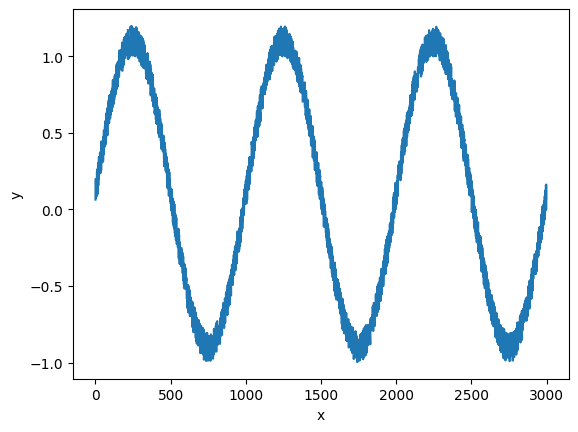

In [329]:
# --- Dataset 1
#x_data, y_data = F_do_dataset_parab(m=100)
# --- Dataset 2
x_data, y_data = F_do_dataset_sin(m=3000)

plt.plot(x_data.numpy(), y_data.numpy());
plt.xlabel('x'), plt.ylabel('y');

print('size of x_data:', x_data.size())
print('size of y_data:', y_data.size())

## Data standardization

We standardize the input data (substract mean and divide by standard-deviation)

In [330]:
# --- START CODE HERE
x_data = (x_data-x_data.mean())/x_data.std()
# --- END CODE HERE

## Hyper-parameters definition

In [331]:
n_in = 1
n_h = 10
n_out = 1

nb_epoch = 20000
learning_rate_alpha = 0.05
param_momentum = 0.01
param_L1_weight = 0.001
param_L2_weight = 0.01

## Model A (writting the network equations)

For model A, you will define the variables and write the equations of the network yourself (as you would do in numpy).
However you will use ```torch tensors``` instead of ```numpy array```.

***Why ?*** because torch tensors will allows you to automatically get the gradient. You will use ```loss.backward()``` to launch the backpropagation from the ```loss``` variable.
Then, for all torch tensors you have created and for which you have declared ```requires_grad=True```, you will get the gradient of ```loss```with respect to this variable in the field ```.grad```.

***Example*** ```W1 = torch.tensors(..., requires_grad=True)``` ... ```loss.backward()``` will have the gradient $\frac{d Loss}{d W1}$in ```W1.grad```.

### Initialize the variables

**Note**: In order to avoid neuron saturation and that all the neurons learn the same thing, the matrix should be initialized to a small random value (see https://pytorch.org/docs/stable/generated/torch.nn.Linear.html for details). Because of this, W1 and W2 should be first define as small random; **then** set to ```requires_grad=True```.

In [332]:
# --- START CODE HERE
W1 = torch.randn(n_in,n_h)
W1.requires_grad_(True)
b1 = torch.zeros(n_h,requires_grad=True,dtype=torch.float)
W2 = torch.randn(n_h,n_out)
W2.requires_grad_(True)
b2 = torch.zeros(n_out,requires_grad=True,dtype=torch.float)
# --- END CODE HERE

### Define the model

We will denote by ```H``` the pre-activation (value before the non-linearity) and by ```A``` the activation (value after the non-linearity).

### Train the model

**Note**: when updating the parameters (W1,b1,W2,b2) you should use an "in-place" update: ```W1 -= ...``` instead of ```W1 = W1 - ...```; otherwise ```W1``` will be replaced by its value and its gradient field will not exist anymore.

In [333]:
y_data.pow(2).sum()

tensor(1538.7163)

In [334]:
learning_rate_alpha=10e-6

In [335]:
for epoch in range(0, nb_epoch):
    # --- X (m, n_in)
    # --- Y (m, n_out)
    # --- START CODE HERE
    H=x_data.mm(W1)+b1
    A = F.sigmoid(H)
    y_pred = F.hardtanh(A.mm(W2)+b2)
    # --- loss
    loss = (y_pred - y_data).pow(2).sum()
    # --- backward
    loss.backward()
    # --- END CODE HERE
    if epoch % 1000 == 0:
        learning_rate_alpha*=1.2
        print('epoch {}, loss {}'.format(epoch, loss))



    with torch.no_grad():
        # --- START CODE HERE
        # --- update
        W1 -= learning_rate_alpha * W1.grad
        W2 -= learning_rate_alpha * W2.grad
        b1 -= learning_rate_alpha * b1.grad
        b2 -= learning_rate_alpha * b2.grad
        # --- END CODE HERE
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
    nn.utils.clip_grad_norm_([W1, W2, b1, b2], max_norm=1.0)


epoch 0, loss 2888.2783203125
epoch 1000, loss 1400.05078125
epoch 2000, loss 1379.1302490234375
epoch 3000, loss 1349.59619140625
epoch 4000, loss 1329.6478271484375
epoch 5000, loss 1317.996337890625
epoch 6000, loss 1308.451416015625
epoch 7000, loss 1300.27880859375
epoch 8000, loss 1293.3170166015625
epoch 9000, loss 1287.413330078125
epoch 10000, loss 1282.4228515625
epoch 11000, loss 1280.887939453125
epoch 12000, loss 1333.87109375
epoch 13000, loss 1277.037109375
epoch 14000, loss 1266.5885009765625
epoch 15000, loss 1274.89892578125
epoch 16000, loss 1214.947509765625
epoch 17000, loss 1242.7176513671875
epoch 18000, loss 1167.593017578125
epoch 19000, loss 1010.1058349609375


### Plotting the results

We will super-impose the biases of the first layer to better understand how the model has fit the sinusoidal curve. Please explain what it does.

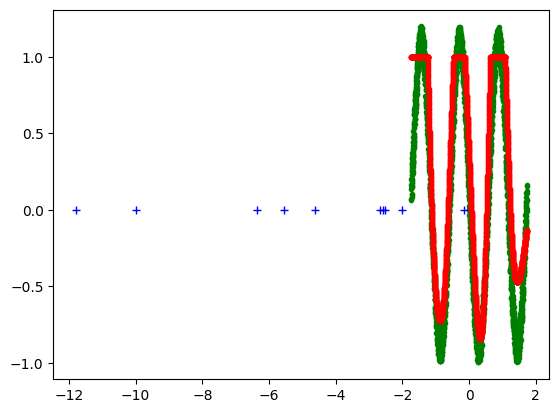

In [336]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g.');
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r.');
# super-impose the biases of the first layer
plt.plot(b1.detach().numpy(), np.zeros((n_h,n_in)), 'b+');

## Model B (using Sequential class)

Here, you will write the network using the nn.Sequential class.
With this you can use the ready-made layers ``torch.nn.Linear``,``torch.nn.Tanh``, ...

In [337]:
# --- START CODE HERE
modelB = nn.Sequential(nn.Linear(n_in,n_h), nn.Sigmoid() ,nn.Linear(n_h,n_in) ,nn.Hardtanh())
# --- END CODE HERE

## Model C (using a class definition)

Here, you will write the network using the recommended pytorch way; i.e. by defining a class.
This class inherit from the main class ```torch.nn.Module```.
You only need to write the ```__init__``` method and the ```forward``` method.

In object programming, the ```__init__``` method defines the attributes of your class. Since the attributes of your  network are the parameters to be trained (weights and biases), you should declare in the ```__init``` all the layers that involve parameters to be trained (mostly the ```Linear```layers which perform the matrix multiplication).

The ```forward``` method contains the code of the forward pass itself. It can of course call attributes defined in the ```__init___``` method. It is the method used when calling ```model(x)```.

As before, the model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```.

Classes are convenient way to write more complex network than what you can do with ```nn.sequential```. Note that you can actually include a ```nn.sequential``` in your class.

In [348]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # --- START CODE HERE
        self.in_layer  = nn.Linear(n_in , n_h)
        self.out_layer  = nn.Linear(n_h, n_out)
        self.relu= nn.ReLU()
        self.tanh = nn.Tanh()
        # --- END CODE HERE

    def forward(self, x):

        # --- START CODE HERE
        y = self.in_layer(x)
        y= self.relu(y)
        y = self.out_layer(y)
        y_pred = self.tanh(y)
        # --- END CODE HERE

        return y_pred

# --- START CODE HERE
modelC = Net()
# --- END CODE HERE

## Model B+C

### Criterion and Optimization

The code of Model A is self-contained, i.e. it already contains all necessary instruction to perform forward, loss, backward and parameter updates.

When using ```nn.sequential``` (model B) or a class definition of the network (model C), we still need to define
- what we will minimize (the loss to be minimized, i.e. Mean-Square-Error or Binary-Cross-Entropy). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)
- how we will minimize the loss, i.e. what parameter update alogirhtms we will use (SGD, momentum). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)

L2 regularization can be done directly in the optimizer under the name ```weight_decay```.

In [349]:
criterion = nn.MSELoss(reduction='sum')  # Mean Squared Error Loss
optimizerB = torch.optim.SGD(modelB.parameters(), lr=1e-4)
optimizerC = torch.optim.SGD(modelC.parameters(), lr=1e-4,weight_decay=1e-4)

### Training

Having defined the network, the citerion to be minimized and the optimizer, we then perform a loop over epochs (iterations); at each step we
- compute the forward pass by passing the data to the model: ```haty = model(x)```
- compute the the loss (the criterion)
- putting at zero the gradients of all the parameters of the network (this is important since, by default, pytorch accumulate the gradients over time)
- computing the backpropagation (using as before ```.backward()```)
- performing one step of optimization (using ```.step()```)

Epoch 0, Loss: 1758.2825
Epoch 1000, Loss: 1409.3857
Epoch 2000, Loss: 1406.5992
Epoch 3000, Loss: 1319.1803
Epoch 4000, Loss: 1285.0745
Epoch 5000, Loss: 1224.8451
Epoch 6000, Loss: 989.4743
Epoch 7000, Loss: 892.0957
Epoch 8000, Loss: 847.6558
Epoch 9000, Loss: 834.1501
Epoch 10000, Loss: 820.8749
Epoch 11000, Loss: 776.6204
Epoch 12000, Loss: 282.7433
Epoch 13000, Loss: 166.4517
Epoch 14000, Loss: 158.2649
Epoch 15000, Loss: 149.2394
Epoch 16000, Loss: 149.9451
Epoch 17000, Loss: 157.7542
Epoch 18000, Loss: 152.6313
Epoch 19000, Loss: 146.1879


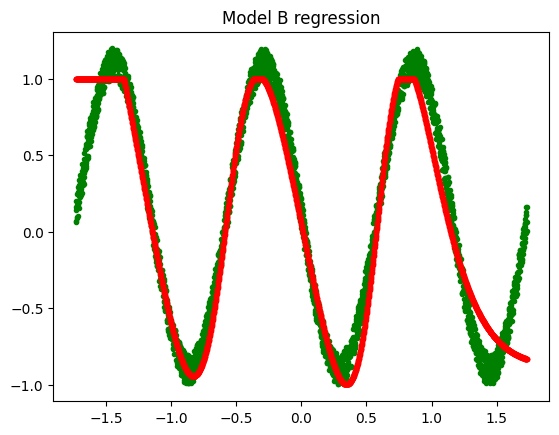

In [340]:
# --- START CODE HERE
loss_lB= []
# Training loop
for epoch in range(nb_epoch):
    modelB.train()  # Set the model to training mode
    optimizerB.zero_grad()  # Zero the gradients

    # Forward pass
    y_pred = modelB(x_data)

    # Calculate loss
    loss = criterion(y_pred, y_data)
    loss_lB.append(loss)
    # Backward pass
    loss.backward()
    optimizerB.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


modelB.eval()
y_pred =  modelB(x_data)
plt.plot(x_data.numpy(), y_data.numpy(), 'g.');
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r.');
plt.title('Model B regression')
plt.show()
# super-impose the biases of the first layer
# --- END CODE HERE

Epoch 0, Loss: 1643.1952
Epoch 1000, Loss: 253.5342
Epoch 2000, Loss: 204.3233
Epoch 3000, Loss: 197.0607
Epoch 4000, Loss: 192.9162
Epoch 5000, Loss: 189.7512
Epoch 6000, Loss: 187.1992
Epoch 7000, Loss: 185.0665
Epoch 8000, Loss: 183.2389
Epoch 9000, Loss: 181.7130
Epoch 10000, Loss: 180.3814
Epoch 11000, Loss: 179.1950
Epoch 12000, Loss: 178.1660
Epoch 13000, Loss: 177.2570
Epoch 14000, Loss: 176.4520
Epoch 15000, Loss: 175.7141
Epoch 16000, Loss: 175.0498
Epoch 17000, Loss: 174.3949
Epoch 18000, Loss: 173.8486
Epoch 19000, Loss: 173.3391


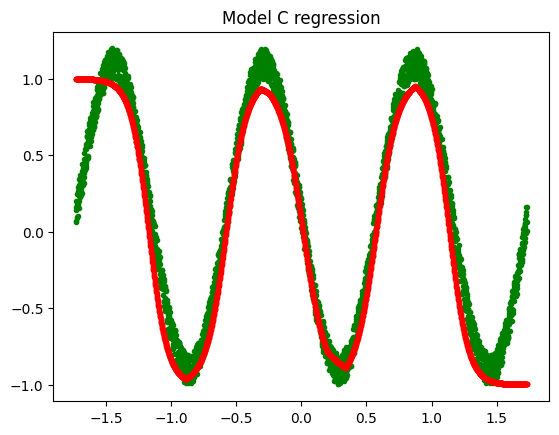

In [350]:
# --- START CODE HERE
loss_lC= []
# Training loop
for epoch in range(nb_epoch):
    modelC.train()  # Set the model to training mode
    optimizerC.zero_grad()  # Zero the gradients

    # Forward pass
    y_pred = modelC(x_data)

    # Calculate loss
    loss = criterion(y_pred, y_data)
    loss_lC.append(loss)
    # Backward pass
    loss.backward()
    optimizerC.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


modelC.eval()
y_pred =  modelC(x_data)
plt.plot(x_data.numpy(), y_data.numpy(), 'g.');
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r.');
plt.title('Model C regression')
plt.show()
# super-impose the biases of the first layer
# --- END CODE HERE


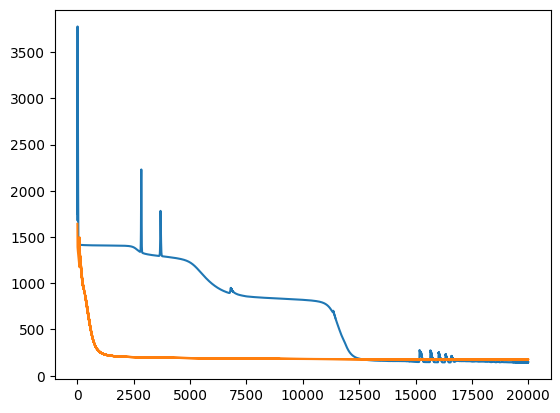

In [351]:
# ----------------
plt.plot([loss.detach().numpy() for loss in loss_lB]);
plt.plot([loss.detach().numpy() for loss in loss_lC]);
plt.show()

### Display the weights and the biases

Now, we want to check the effect of L1 regularization. For this you will plot the values of the weights of each layers.

[[ 0.01464045]
 [ 5.2415304 ]
 [-2.018855  ]
 [ 0.9935785 ]
 [-0.01208642]
 [ 4.259488  ]
 [-4.509003  ]
 [ 1.4526318 ]
 [-0.12265408]
 [-5.204811  ]]
[ 3.6256246e-03 -4.5857949e+00  4.0106684e-01  2.4727315e-01
  2.3930932e-03 -1.4447800e+00 -1.4088999e+00  3.6151674e-01
 -9.1280055e-01 -4.6336164e+00]
[[-0.01172434 -2.491171    1.5628626  -0.8181722   0.0092199   2.023703
  -2.1154923  -1.1961794  -0.11601642  2.588827  ]]
[0.07989967]


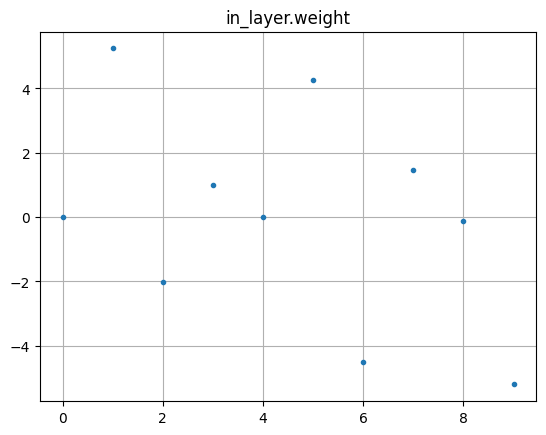

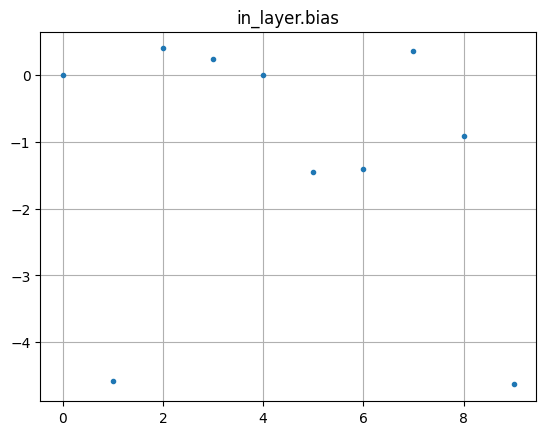

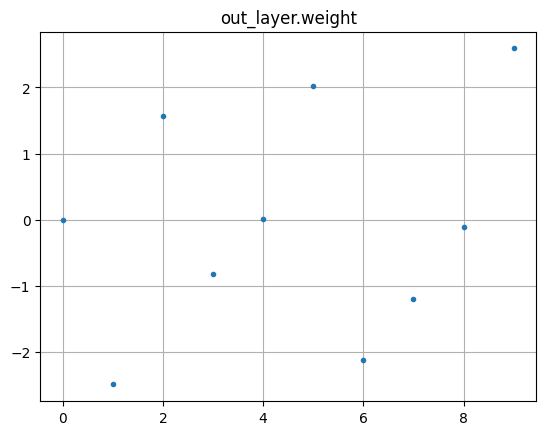

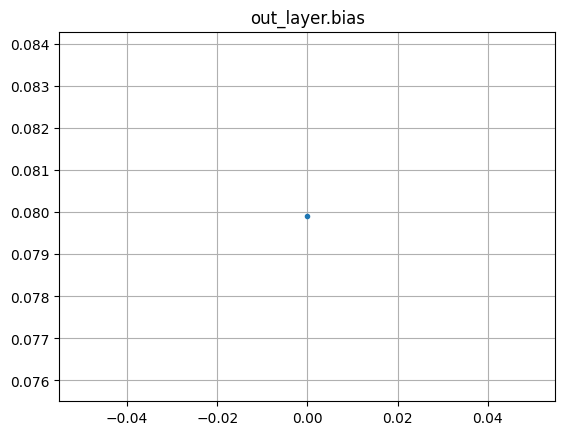

In [352]:
list_l = [{'name':name, 'data':layer.data} for name, layer in modelC.named_parameters()]
for tmp in list_l:
    plt.figure()
    plt.plot(tmp['data'].flatten().numpy(), '.')
    plt.title(tmp['name'])
    plt.grid(True)
    print(tmp['data'].numpy())